# Import Data

In [1]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Flatten, Dense

Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

origin_path = '/content/drive/My Drive/Colab Notebooks/Metamaterials AI/Preprocessed_Images/'

Mounted at /content/drive


# Functions

Resize Images

In [3]:
# Function to resize images while keeping red and yellow regions
def resize_retain_colors(image):
  # Convert the image to the HSV color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define broader bounds for yellow color in HSV
  lower_yellow = np.array([10, 50, 50])
  upper_yellow = np.array([40, 255, 255])

  # Define broader bounds for red color in HSV
  lower_red1 = np.array([0, 50, 50])
  upper_red1 = np.array([10, 255, 255])
  lower_red2 = np.array([160, 50, 50])
  upper_red2 = np.array([180, 255, 255])

  # Create masks for yellow and red colors
  yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
  red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
  red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
  red_mask = red_mask1 + red_mask2

  # Combine red and yellow masks
  mask_combined = cv2.bitwise_or(red_mask, yellow_mask)

  # Extract red and yellow regions from the original image
  regions_of_interest = cv2.bitwise_and(image, image, mask=mask_combined)

  # Resize the regions of interest to the target size
  resized_regions = cv2.resize(regions_of_interest, target_size, interpolation=cv2.INTER_CUBIC)

  return resized_regions


Subplots

In [4]:
def subplots(image1, image2, suptitle, subplot1_title, subplot2_title):
    # Create subplots
    plt.suptitle(suptitle)

    # Adjust the top margin to reduce the gap
    plt.subplots_adjust(top=1.2)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.title(subplot1_title)

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.title(subplot2_title)

    # Show the plot
    plt.show()

# Conversion to Numpy Arrays

Good Images

In [5]:
image = cv2.imread(origin_path + 'Good Image/augmented_0.jpg')
image_array = np.array(image)
print(image_array[250][250])
print("Shape of the image arrayay:", image_array.shape)

[214 254 252]
Shape of the image arrayay: (525, 700, 3)


In [6]:
folder_path = origin_path + 'Good Image/'

# Get the list of all files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
images = []
for file_name in image_files:
  # Construct the full path to the image file
  image_path = os.path.join(folder_path, file_name)
  images.append(cv2.imread(image_path))

In [7]:
images_array = np.array(images)
print(images_array.shape)
print(images_array.shape[0])

(416, 525, 700, 3)
416


In [8]:
# Create an array of labels with a shape matching the number of images
y = np.ones(images_array.shape[0], dtype=int)
print(y.shape)

(416,)


Bad Images

In [9]:
folder_path = origin_path + 'Bad Image/'

# Get the list of all files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
count = 0
for file_name in image_files:
  # Construct the full path to the image file
  count = count + 1
  image_path = os.path.join(folder_path, file_name)
  images.append(cv2.imread(image_path))

In [10]:
# Create an array of labels with a shape matching the number of images
y = np.append(y, np.zeros(count, dtype=int))

In [11]:
images_array = np.array(images)
print(images_array.shape)
y = y.reshape(y.shape[0], 1)
print(y.shape)

(835, 525, 700, 3)
(835, 1)


In [12]:
# Use numpy.unique with return_counts=True
unique_values, counts = np.unique(y, return_counts=True)

# Combine unique values and their counts
value_counts = np.column_stack((unique_values, counts))

print(value_counts)

[[  0 419]
 [  1 416]]


In [13]:
print(y[0])
print(y[415])
print(y[416])
print(y[834])

[1]
[1]
[0]
[0]


# Preprocessing Steps

Reshape

In [14]:
target_size = (224, 224)

# Apply the resize_retain_colors function to each image in images_array
resized_retained_colors_images = [resize_retain_colors(image) for image in images_array]

# Convert the list of resized and retained colors images to a NumPy array
resized_retained_colors_array = np.array(resized_retained_colors_images)

# Display the shape of the original and resized_retained_colors arrays
print("Original images_array shape:", images_array.shape)
print("Resized and Retained Colors images_array shape:", resized_retained_colors_array.shape)

Original images_array shape: (835, 525, 700, 3)
Resized and Retained Colors images_array shape: (835, 224, 224, 3)


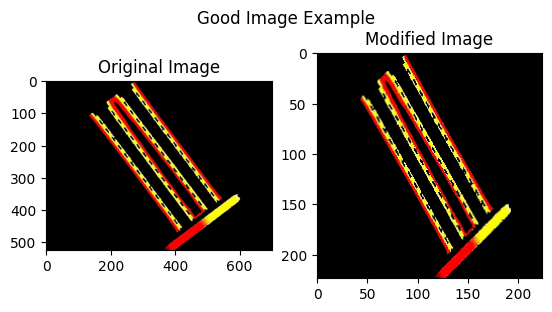

In [15]:
img_no = 50
subplots(image1=images_array[img_no], image2=resized_retained_colors_array[img_no], suptitle='Good Image Example', subplot1_title='Original Image', subplot2_title='Modified Image')

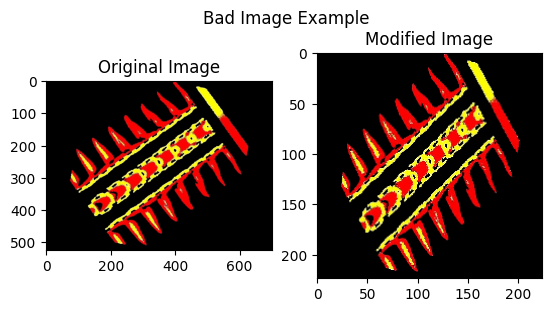

In [16]:
img_no = 516
subplots(image1=images_array[img_no], image2=resized_retained_colors_array[img_no], suptitle='Bad Image Example', subplot1_title='Original Image', subplot2_title='Modified Image')

Normalization

In [17]:
normalized_images = []
resized_images_array = resized_retained_colors_array
for image in resized_images_array:
    normalized_image = image / 255.0
    normalized_images.append(normalized_image)

# Convert the list of normalized images to a NumPy array
normalized_images_array = np.array(normalized_images)

# Display the shape of the resized and normalized arrays
print("Resized images_array shape:", resized_images_array.shape)
print("Normalized images_array shape:", normalized_images_array.shape)

Resized images_array shape: (835, 224, 224, 3)
Normalized images_array shape: (835, 224, 224, 3)


In [18]:
px = 10
print(resized_images_array[img_no][px][px])
print(normalized_images_array[img_no][px][px])

[0 0 0]
[0. 0. 0.]


In [19]:
x = np.array(normalized_images_array)
print(x.shape)

(835, 224, 224, 3)


Train-Test Splitting

In [20]:
bad_no = int(count)
good_no = int(x.shape[0] - count)
print('Good Images', good_no)
print('Bad Images', bad_no)

Good Images 416
Bad Images 419


In [21]:
percentage = 80
train_good = int(good_no * percentage / 100)
test_good = int(good_no * (100 - percentage) / 100)
train_bad = int(bad_no * percentage / 100)
test_bad = int(bad_no * (100 - percentage) / 100)

print('Training Good', train_good)
print('Testing Good', test_good)
print('Training Bad', train_bad)
print('Testing Bad', test_bad)

Training Good 332
Testing Good 83
Training Bad 335
Testing Bad 83


In [22]:
X_train_good = x[:train_good + 1]
Y_train_good = y[:train_good + 1]

X_test_good = x[train_good + 1: train_good + test_good + 1]
Y_test_good = y[train_good + 1: train_good + test_good + 1]

print(len(X_train_good), len(X_test_good), len(Y_train_good), len(Y_test_good))

333 83 333 83


In [23]:
print(Y_train_good[0])
print(Y_test_good[0])
print(Y_train_good[-1])
print(Y_test_good[-1])

[1]
[1]
[1]
[1]


In [24]:
X_train_bad = x[train_good + test_good + 1: train_good + test_good + train_bad + 1]
Y_train_bad = y[train_good + test_good + 1: train_good + test_good + train_bad + 1]


X_test_bad = x[train_good + test_good + train_bad + 1: ]
Y_test_bad = y[train_good + test_good + train_bad + 1: ]

print(len(X_train_bad), len(X_test_bad), len(Y_train_bad), len(Y_test_bad))

335 84 335 84


In [25]:
print(Y_train_bad[0])
print(Y_test_bad[0])
print(Y_train_bad[-1])
print(Y_test_bad[-1])

[0]
[0]
[0]
[0]


In [26]:
X_train = np.concatenate((X_train_good, X_train_bad), axis = 0)
Y_train = np.concatenate((Y_train_good, Y_train_bad), axis = 0)

X_test = np.concatenate((X_test_good, X_test_bad), axis = 0)
Y_test = np.concatenate((Y_test_good, Y_test_bad), axis = 0)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(668, 224, 224, 3) (668, 1)
(167, 224, 224, 3) (167, 1)


In [27]:
print(Y_train[0])
print(Y_train[331])
print(Y_train[332])
print(Y_train[333])
print(Y_train[334])
print(Y_train[-1])

[1]
[1]
[1]
[0]
[0]
[0]


In [28]:
print(Y_test[0])
print(Y_test[81])
print(Y_test[82])
print(Y_test[83])
print(Y_test[84])
print(Y_test[-1])

[1]
[1]
[1]
[0]
[0]
[0]


In [29]:
# Use numpy.unique with return_counts=True
unique_values, counts = np.unique(Y_train, return_counts=True)

# Combine unique values and their counts
value_counts = np.column_stack((unique_values, counts))

print(value_counts)

[[  0 335]
 [  1 333]]


In [30]:
# Use numpy.unique with return_counts=True
unique_values, counts = np.unique(Y_test, return_counts=True)

# Combine unique values and their counts
value_counts = np.column_stack((unique_values, counts))

print(value_counts)

[[ 0 84]
 [ 1 83]]


# Model Training

AlexNet

In [31]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()

Form Input, Hidden, Output Layers

In [32]:
'''from keras.applications.alexnet import AlexNet

base_model = AlexNet(include_top=False, input_shape=(227,227,3))

# include fully connected layers
base_model.trainable = True # Not Freezing CNN layers'''

'from keras.applications.alexnet import AlexNet\n\nbase_model = AlexNet(include_top=False, input_shape=(227,227,3))\n\n# include fully connected layers\nbase_model.trainable = True # Not Freezing CNN layers'

In [33]:
#base_model.summary()

In [34]:
'''from keras.layers import Dropout , GlobalAveragePooling2D
from keras import layers, models

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])'''

"from keras.layers import Dropout , GlobalAveragePooling2D\nfrom keras import layers, models\n\nmodel = models.Sequential([\n    base_model,\n    GlobalAveragePooling2D(),\n    layers.BatchNormalization(),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(64, activation='relu'),\n    layers.Dense(1, activation='sigmoid')\n])"

In [35]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

Compile the Model

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Callbacks

In [38]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

Fit the Model

In [39]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 256,
                    epochs = 10,
                    callbacks=[callback])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 2.7574 - accuracy: 0.4644
Epoch 1: saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 21s 2s/step - loss: 2.7574 - accuracy: 0.4644 - val_loss: 0.8055 - val_accuracy: 0.0000e+00
Epoch 2/10
2/3 [===================>..........] - ETA: 0s - loss: 1.4131 - accuracy: 0.8086
Epoch 2: saving model to best_model.h5
3/3 [==============================] - 1s 580ms/step - loss: 1.3672 - accuracy: 0.8146 - val_loss: 0.0941 - val_accuracy: 1.0000
Epoch 3/10
2/3 [===================>..........] - ETA: 0s - loss: 0.3519 - accuracy: 0.8984
Epoch 3: saving model to best_model.h5
3/3 [==============================] - 1s 411ms/step - loss: 0.3382 - accuracy: 0.9026 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 4/10
2/3 [===================>..........] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 4: saving model to best_model.h5
3/3 [==============================] - 4s 2s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 1.0000
Epoch 5/10
2/3 [===================>..........] - ETA: 0s - loss: 0.0349 - accuracy: 0.9922


# Plot Model Progression

Accuracy (training vs validation dataset)

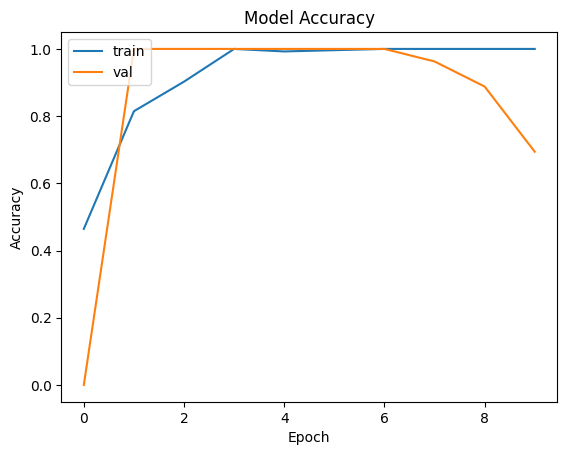

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

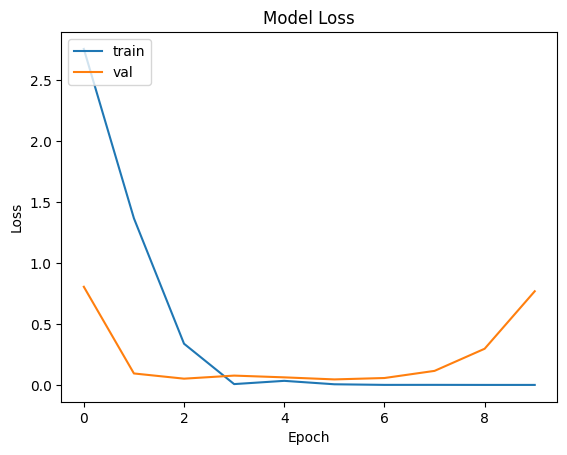

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Combined Loss & Accuracy

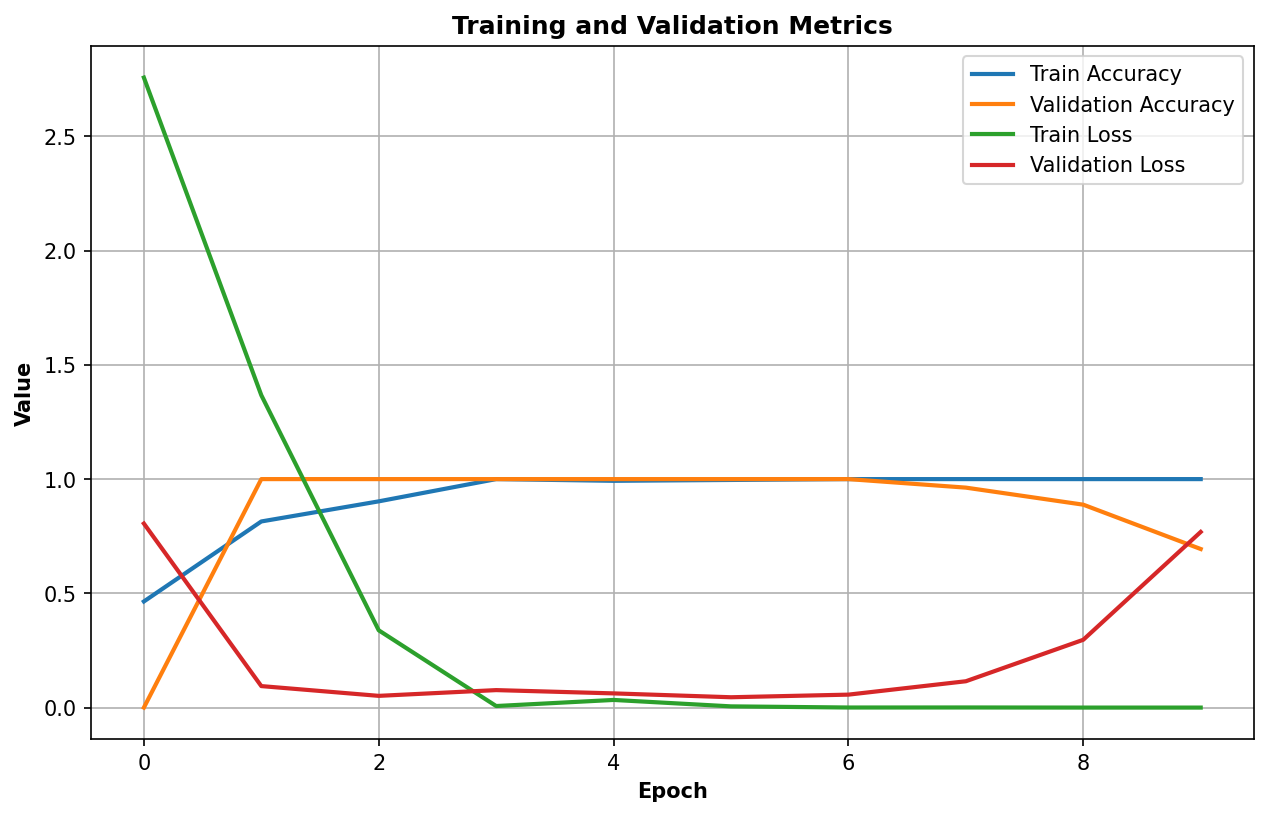

In [42]:
# Plot the training and validation accuracy and loss over epochs
plt.figure(figsize=(10, 6), dpi=150)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Training and Validation Metrics', fontweight='bold')
plt.legend()
plt.grid(True)

# Save the figure
#plt.savefig('accuracy_loss_curve.png', dpi=300)
plt.show()

Load best model weights

In [43]:
model.load_weights('best_model.h5')

Print model weights

In [44]:
'''# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_model.h5')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_model_squeezenet.h5')

# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())'''

'# Load your pre-trained model (replace \'model.h5\' with your model\'s filename)\nbest_model = tf.keras.models.load_model(\'best_model.h5\')\n# Define the path where you want to save the model\nmodel_save_path = \'/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/\'\n\n# Save the best model to Google Drive\nbest_model.save(model_save_path + \'best_model_squeezenet.h5\')\n\n# Get the list of all layers in the model\nall_layers = best_model.layers\n\n# Loop through the layers and print their weights if they have any\nfor layer in all_layers:\n    if layer.weights:\n        print(f"Layer: {layer.name}")\n        for weight in layer.weights:\n            print(f"  {weight.name}:")\n            print(weight.numpy())'

# Model Testing

Results

In [45]:
results = model.evaluate(X_test,  Y_test, verbose = 0)
print('test loss, test acc:', results)

test loss, test acc: [0.8211022019386292, 0.6227545142173767]


In [46]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

6/6 [==============================] - 0s 12ms/step


In [47]:
#print(y_pred_ohe)

In [48]:
threshold = 0.97
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [49]:
# Save predictions as a NumPy array
np.save('squeezenet_predictions.npy', y_pred_labels)

In [50]:
#print(y_pred_labels)

In [51]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[76  8]
 [ 0 83]]


In [52]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       1.00      0.90      0.95        84
   malignant       0.91      1.00      0.95        83

    accuracy                           0.95       167
   macro avg       0.96      0.95      0.95       167
weighted avg       0.96      0.95      0.95       167



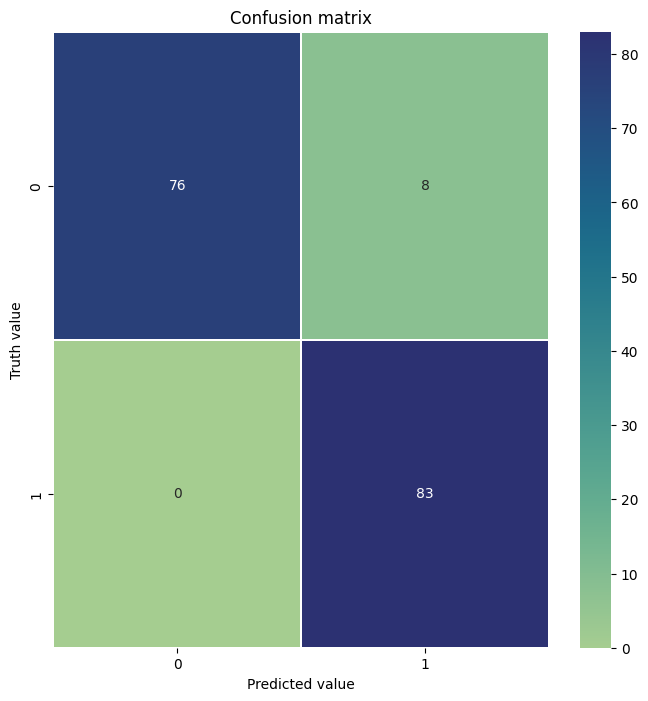

In [53]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.91
Recall: 1.00
F1-score: 0.95


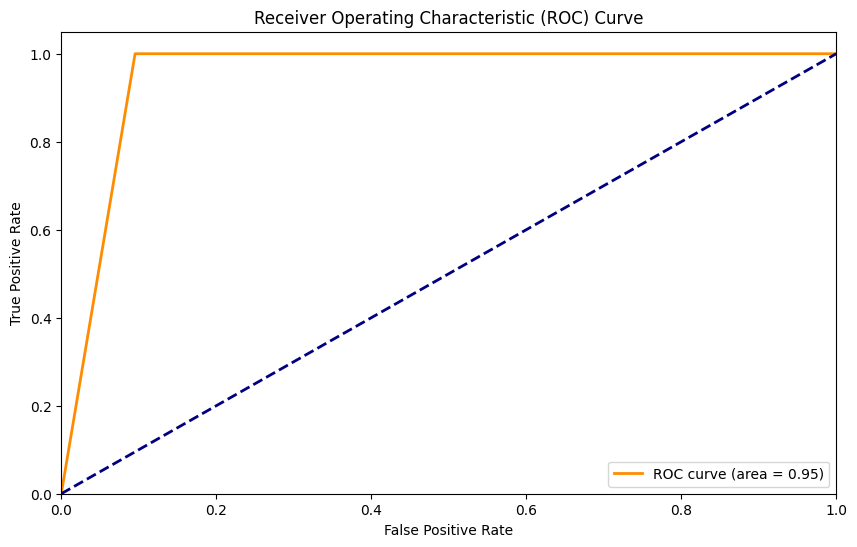

In [55]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()